In [1]:
import collections
import numpy as np

from typing import Tuple
from typing import List

from xtype import Float
from xtype import ImmutableArray
from xtype import ImmutableTensor
from xtype import MutableTensor
from xtype import Iterator

from exp_utils import *
import ops

dataset = gen_random_dataset()

2 batches is generated.
batch 0 has 2 passages.
  |__ passage 0 has 4 sentences.
    |__ sentence 0 has 7 words.
    |__ sentence 1 has 8 words.
    |__ sentence 2 has 3 words.
    |__ sentence 3 has 10 words.
  |__ passage 1 has 2 sentences.
    |__ sentence 0 has 10 words.
    |__ sentence 1 has 3 words.
batch 1 has 3 passages.
  |__ passage 0 has 6 sentences.
    |__ sentence 0 has 7 words.
    |__ sentence 1 has 6 words.
    |__ sentence 2 has 6 words.
    |__ sentence 3 has 4 words.
    |__ sentence 4 has 2 words.
    |__ sentence 5 has 8 words.
  |__ passage 1 has 2 sentences.
    |__ sentence 0 has 2 words.
    |__ sentence 1 has 7 words.
  |__ passage 2 has 3 sentences.
    |__ sentence 0 has 3 words.
    |__ sentence 1 has 5 words.
    |__ sentence 2 has 10 words.


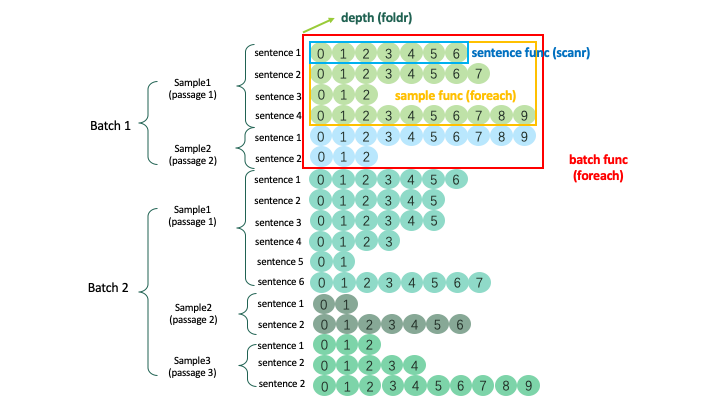

In [2]:
from IPython.display import Image
Image(filename='images/data.png')

# Define hyperparameters

Hyperparameters are constants that will not change during training.

In [3]:
# ============  hyper parameters constants independent of data ============== #
embed_size = 16
word_num = 25
proj_size = 16
input_size = 16
hidden_size = 16
output_size = hidden_size
depth = 3

# Define learnable parameters

Learnable parameters are mutable tensors that have static shapes. They have global liveness.

In [4]:
# =====  Learnable parameters that have static shapes and global liveness. ==#
# Learnable parameters are mutable. They will be updated by optimizer.

# Learnable parameter for the Embedding layer.
embed_table: MutableTensor = as_tensor(np.random.randn(word_num, embed_size),
                                       mutable=True)

# Learable parameter for the FC layer.
proj_matrix: MutableTensor = as_tensor(np.random.randn(embed_size, proj_size),
                                       mutable=True)

rnn_params = []
for i in range(depth):
    Wi = as_tensor(np.random.randn(input_size, hidden_size), mutable=True)
    Wu = as_tensor(np.random.randn(hidden_size, hidden_size), mutable=True)
    b = as_tensor(np.random.randn(1, output_size), mutable=True)
    rnn_params.append(ImmutableArray([Wi, Wu, b]))

# Array is immutable, but array element is mutable.
rnn_params: ImmutableArray = ImmutableArray(rnn_params)

pre_softmax_proj: MutableTensor = as_tensor(np.random.randn(output_size, 2),
                                            mutable=True)

# Define computations

In [5]:
def RNNCell(input: ImmutableTensor, h: ImmutableTensor, Wi: ImmutableTensor,
            Wu: ImmutableTensor, b: ImmutableTensor):
    input2hidden = ops.MatMul(input, Wi)
    hidden2hidden = ops.MatMul(h, Wu)
    output = ops.Add(input2hidden, hidden2hidden)
    return ops.Tanh(ops.Add(output, b))


def word_func(iterator: Iterator, h_prev: ImmutableTensor,
              word: int) -> ImmutableArray:
    word_emb = ops.SelectRows([word], embed_table)
    # `fold` returns output of the last layer
    depth_out: ImmutableArray = rnn_params.fold(RNNCell,
                                                init=word_emb,
                                                h_prev=h_prev)
    return depth_out


def sentence_func(iterator: Iterator,
                  sentence: ImmutableArray) -> ImmutableArray:
    """User defined computation applied to a single sentence.
    """
    seq_encodes = sentence.scan(word_func,
                                init=as_tensor(np.zeros((1, hidden_size))))
    return seq_encodes.last()


def sample_func(iterator: Iterator, sample: ImmutableArray) -> ImmutableTensor:
    """User defined computation that is applied to a single training sample.

    In this example, a training sample is a passages which is made up of
    several variable length sentences.
    """
    passage_vecs: ImmutableArray = sample.foreach(sentence_func)
    passage_enc = passage_vecs.reduce(ops.Add)

    proj = ops.MatMul(passage_enc[0], pre_softmax_proj)  # tensor operation
    softmax = ops.Softmax(proj)
    return softmax


def batch_func(iterator: Iterator, batch: ImmutableArray):
    """
    User defined computation that is applied to a single batch in the training
    set.

    In this example, a batch is made up of several passages.
    """

    output: ImmutableArray = batch.foreach(sample_func)
    """ Not implemented.
    loss_sum = reduce(lambda x, y: x + y, output)  # forward
    backward(loss_sum)  # backward

    # get paramters from the global scope.
    update(get_paramters())  # optimizer
    """

dataset.foreach(batch_func)

ImmutableArray, shape = 2, dtype = NoneType